<a href="https://colab.research.google.com/github/Fagner608/visao_computacional_cifar10/blob/main/pratica_v_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# imports
import torch
from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision.transforms import transforms

import numpy as np
import matplotlib.pylab as plt

In [16]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5), (.5,.5,.5))
])


# loader data
dados_treino = datasets.CIFAR10(
    'data',
    train = True,
    download=True,
    transform=transform
)

dados_teste = datasets.CIFAR10(
    'data',
    train = False,
    download=True,
    transform=transform
)

dados_treino, dados_validacao = random_split(dados_treino, [.7, .3])

#dataloaders
loader_treino = torch.utils.data.DataLoader(dados_treino, batch_size=20, num_workers=0)
loader_validacao = torch.utils.data.DataLoader(dados_validacao, batch_size=20, num_workers=0)
loader_teste = torch.utils.data.DataLoader(dados_teste, batch_size=20, num_workers=0)

In [4]:
print(len(dados_treino))
print(len(dados_validacao))
print(len(dados_teste))

35000
15000
10000


In [17]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

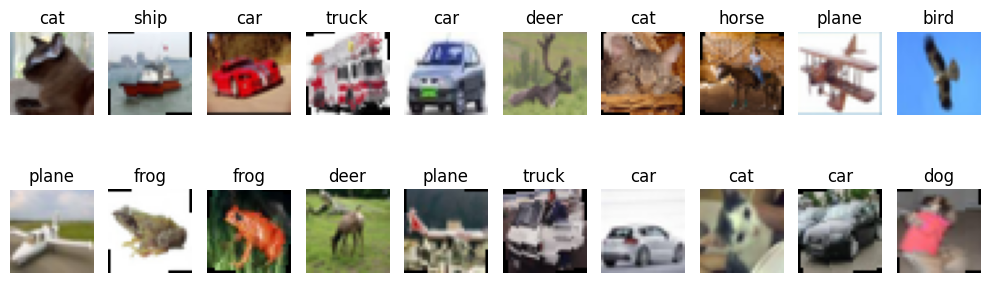

In [18]:
# visualizando
fig = plt.figure(figsize = (10,5))
col = 10
row = 2
for idx in range(col * row):

  image, label = dados_treino[idx]
  fig.add_subplot(row, col, idx + 1)
  img = image / 2 +.5
  img = img.numpy()
  img = np.transpose(img, (1, 2, 0))

  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(classes[label])
  plt.axis('off')
  plt.tight_layout()



**Forward**

In [31]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # observar que a saída é 64, mesmo argumento da nn.Linear
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 500) # a dimensão da saída é a mesma da entrada da próxima
        self.fc2 = nn.Linear(500, 10) # a dimensão de saída é o len(classes)
        self.dropout = nn.Dropout(.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))


        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = self.dropout(x)

        x = F.relu(self.fc1(x))

        x = self.dropout(x)

        x = self.fc2(x)

        return x


In [32]:
modelo = Net()

In [13]:
modelo.cuda()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [33]:
# loss e optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelo.parameters(), lr = 0.01)

In [34]:
# montando função de aplicação
erro_valid_min = torch.inf
num_epochs = 60

for epoch in range(num_epochs):

    erro_treino = 0.0
    erro_valid = 0.0

    modelo.train() # nunca esquecer

    for idx, batch_idx in enumerate(loader_treino):

        optimizer.zero_grad()

        image, label = batch_idx
        # data, target = image.cuda(), label.cuda()

        data, target = image, label
        #treina
        output = modelo(data)

        # captura loss
        loss = criterion(output, target)
        loss.backward()

        #backpropagation
        optimizer.step()


        #erro
        erro_treino += loss.item() * data.size(0)


    modelo.eval()

    for idx, batch_idx in enumerate(loader_validacao):

      image, label = batch_idx
      # data, target = image.cuda(), label.cuda()
      data, target = image, label

      output = modelo(data)
      loss = criterion(output, target)
      erro_valid += loss.item() * data.size(0)

    erro_treino = erro_treino / len(loader_treino)
    erro_valid = erro_valid / len(loader_validacao)

        # visualizando erro
    # print(f"\nEpoch: {epoch}\t Erro em treinamento: {erro_train}\t Erro em validação: {erro_valid}")
    print('\nEpoch: {} \tErro em treinamento: {:.6f}\t Erro em validação: {:.6f}'.format(epoch, erro_treino, erro_valid))
    print('\nEpoch: {} \tProb em treinamento: {:.6f}\t Prob em validação: {:.6f}'.format(epoch, np.exp(-erro_treino), np.exp(-erro_valid)))

    # persistindo modelo
    if erro_valid <= erro_valid_min:
      # print(f"Erro em validação reduzido {erro_valid_min} --> {erro_valid}. Salvando novo modelo...")
      print("\nErro em validação reduzido ({:.6f} --> {:.6f}). Salvando modelo...".format(erro_valid_min, erro_valid))
      torch.save(modelo.state_dict(), 'modelo_final.pt') #salva em formato pytorch
      erro_valid_min = erro_valid


Epoch: 0 	Erro em treinamento: 2.191769	 Erro em validação: 1.963635

Epoch: 0 	Prob em treinamento: 0.111719	 Prob em validação: 0.140347

Erro em validação reduzido (inf --> 1.963635). Salvando modelo...

Epoch: 1 	Erro em treinamento: 1.866808	 Erro em validação: 1.682882

Epoch: 1 	Prob em treinamento: 0.154616	 Prob em validação: 0.185838

Erro em validação reduzido (1.963635 --> 1.682882). Salvando modelo...

Epoch: 2 	Erro em treinamento: 1.666073	 Erro em validação: 1.547798

Epoch: 2 	Prob em treinamento: 0.188988	 Prob em validação: 0.212716

Erro em validação reduzido (1.682882 --> 1.547798). Salvando modelo...

Epoch: 3 	Erro em treinamento: 1.566215	 Erro em validação: 1.478587

Epoch: 3 	Prob em treinamento: 0.208834	 Prob em validação: 0.227960

Erro em validação reduzido (1.547798 --> 1.478587). Salvando modelo...

Epoch: 4 	Erro em treinamento: 1.496637	 Erro em validação: 1.407855

Epoch: 4 	Prob em treinamento: 0.223882	 Prob em validação: 0.244668

Erro em validaçã

### **Como carregar o modelo treinado**

- Instancia a classe Net()
- no objeto instanciando:
  - método load_state_dict(torch.load())

In [35]:
modelo_carregado = Net() #obs: a pessoa que vai carregar não vai ter o modelo que eu crie, neste caso, a função Net() padrão serve?
modelo_carregado.load_state_dict(torch.load('modelo_final.pt'))

<All keys matched successfully>

###**Testando e avaliando o modelo**

O modelo é testando utilizando o mesmo processo da validação. É considerado bom o modelo que tenha precisão nas previsões >= 70%.

No teste, vamos calcular a acurácia junto.

In [36]:
## control de acertos do modelo
class_correct = list(0. for i in range(10)) # vetor de 0 para cada classe
class_correct

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [37]:
class_total = list(0. for i in range(10)) # vetor de 0 para cada classe
class_total

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [39]:
# instanciando erro no loss
erro_teste = 0.0

In [41]:
# tem que iniciar com o modo avaliação
modelo.eval()

# loop apenas nos batchs de dados
for idx, batch_idx in enumerate(loader_teste):

  # obtem dados
  image, label = batch_idx
  # data, target = image.cuda(), label.cuda()
  data, target = image, label
  # aplica
  output = modelo(data)

  #calcula loss
  loss = criterion(output, target)


  # salva loss
  erro_teste += loss.item() * data.size(0)

  ## do output vamos capturar a classe com a maior previsão
  _, pred = torch.max(output, 1)

  ## comparando previsão com label real
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.cpu().numpy())
  # correct = np.squeeze(correct_tensor.cpu().numpy()) caso haja GPU

  ## calculando precisao
  #20 = batch size
  for i in range(20):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

## erro médio em teste
erro_teste = erro_teste / len(loader_teste.dataset)
print(f"\nErro em teste: {round(erro_teste, 6)}")

## Calcula a acurácia para cada classe
for i in range(10):
  if class_total[i] > 0:
    print(f"Acurácia em teste da classe {classes[i]}: {round(100*class_correct[i]/class_total[i])}")

  else:
    print(f"Acurácia em teste de {classes[i]}")


## calcula a acurácia total
print(f"Acurácia em teste total {100. * np.sum(class_correct) / np.sum(class_total)}")


Erro em teste: 0.706891
Acurácia em teste da classe plane: 78
Acurácia em teste da classe car: 83
Acurácia em teste da classe bird: 63
Acurácia em teste da classe cat: 51
Acurácia em teste da classe deer: 78
Acurácia em teste da classe dog: 60
Acurácia em teste da classe frog: 89
Acurácia em teste da classe horse: 76
Acurácia em teste da classe ship: 91
Acurácia em teste da classe truck: 86
Acurácia em teste total 75.47


###**Prevendo uma classe**

In [78]:
# otendo um batch de dado
dataiter = iter(loader_teste)
images, labels = next(dataiter)
## convertendo tensores para array
images.numpy()

array([[[[-1.        , -1.        , -0.05882353, ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -0.00392157, ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        ,  0.01176476, ...,  0.254902  ,
           0.30196083,  0.2941177 ],
         ...,
         [-0.8117647 , -0.62352943, -0.30196077, ..., -0.60784316,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -0.60784316,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -0.46666664,
          -1.        , -1.        ]],

        [[-1.        , -1.        , -0.30196077, ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -0.26274508, ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -0.27058822, ..., -0.12156862,
          -0.0745098 , -0.09019607],
         ...,
         [-0.3960784 , -0.2235294 

In [79]:
# caso haja GPU
# images.cuda()

In [80]:
# fazendo previsão com modelo
output = modelo(images)

In [81]:
# capturando maior probabilidade
_, prob = torch.max(output, 1)
preds = np.squeeze(prob.cpu().numpy())

Entre parênteses a classe real. Vermelhe significa erro do modelo. 



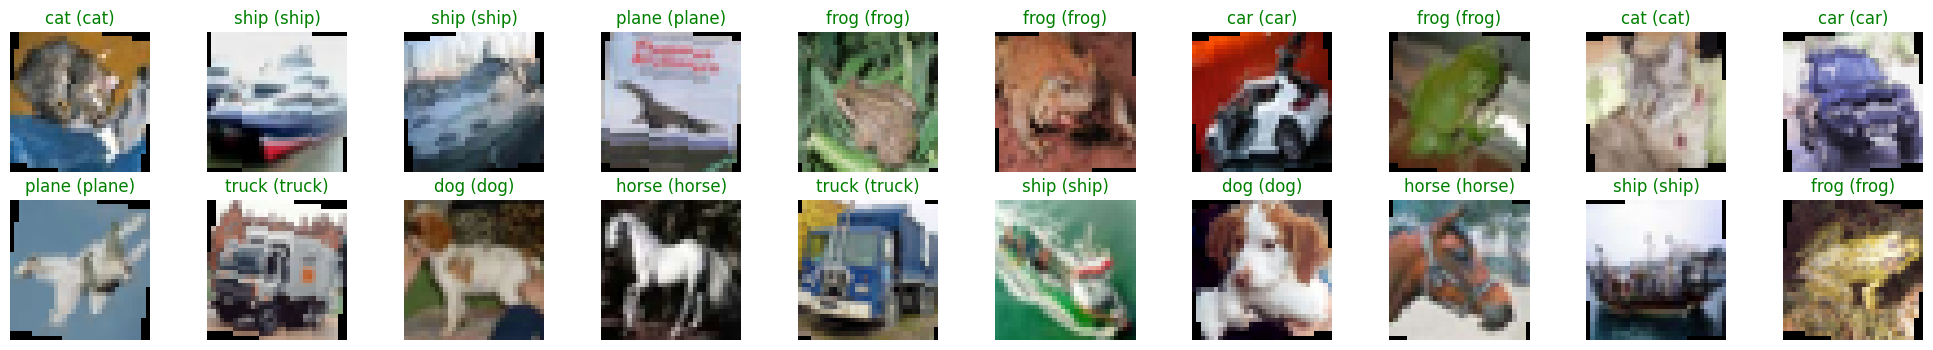

In [82]:
## plot da saída
fig = plt.figure(figsize = (25, 4))
print(f"Entre parênteses a classe real. Vermelhe significa erro do modelo. \n")
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx + 1)
  img = images[idx].cpu()
  label = labels[idx].cpu()
  img = img / 2 +.5
  img = img.numpy()
  img = np.transpose(img, (1,2,0))
  plt.imshow(img)
  plt.axis('off')
  ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
               color = ("green" if preds[idx] == labels[idx].item() else 'red'))

In [83]:
from PIL import Image
from google.colab import files



In [84]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # CIFAR-10 tem 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])




In [108]:
uploaded = files.upload()

Saving Screenshot from 2025-04-14 23-57-12.png to Screenshot from 2025-04-14 23-57-12.png


In [109]:
img_path = list(uploaded.keys())[0]
img  = Image.open(img_path).convert('RGB') # garantindo 3 canais

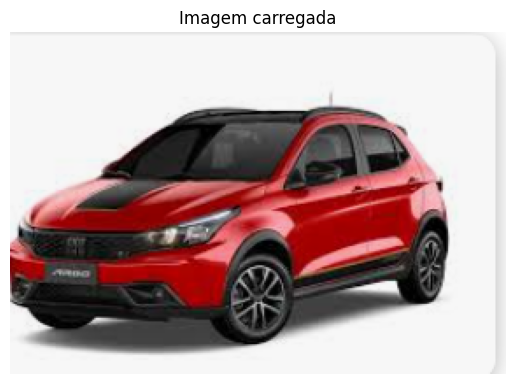

In [110]:
plt.imshow(img)
plt.title("Imagem carregada")
plt.axis("off")
plt.show()

In [111]:
 #Aplica transformações
img_tensor = transform(img)

# Adiciona dimensão batch: (1, 3, 32, 32)
img_tensor = img_tensor.unsqueeze(0)


In [112]:
modelo.eval()
with torch.no_grad():
    output = modelo(img_tensor)
    pred = output.argmax(dim=1).item()

# Mostra a classe prevista
print(f"Classe prevista: {classes[pred]}")

Classe prevista: car
